# Preference Learning

### Mikołaj Nowak 151813  
### Anna Roszkiewicz 151883

---

## Wprowadzenie

Celem projektu jest przeprowadzenie eksperymentów z zakresu *preference learning* z wykorzystaniem różnych modeli klasyfikacyjnych.  
Analiza będzie obejmowała zarówno interpretowalne metody klasyczne, jak i modele oparte na sieciach neuronowych.  

---

## Import niezbędnych bibliotek

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import shap

---

## Wybrany zbiór danych

Jako zbiór danych wybraliśmy **Mammographic Mass Dataset**, ponieważ:

- Zawiera **ponad 900 przykładów**,
- Obejmuje **pięć cech wejściowych**, które są monotoniczne,
- Klasa decyzyjna przyjmuje **dwie wartości** (`0` - łagodny guz, `1` - złośliwy guz),
- Jest to najbardziej kompletny i czysty zbiór spośród dostępnych na stronie  
  [Monotone Learning Datasets – Uni Paderborn](https://en.cs.uni-paderborn.de/is/research/research-projects/software/monotone-learning-datasets).

In [27]:
import pandas as pd

df = pd.read_csv('data/mammographic.csv')
df.head()

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,5,58,4,5,3,1
2,4,28,1,1,3,0
3,5,57,1,5,3,1
4,5,76,1,4,3,1


In [28]:
X, y = df.drop(columns=['Severity']), df['Severity']
X.describe()

,BI-RADS,Age,Shape,Margin,Density
count,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663
std,1.888371,14.671782,1.242361,1.567175,0.350936
min,0.000000,18.000000,1.000000,1.000000,1.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000


In [29]:
y.value_counts()

Severity
0    427
1    403
Name: count, dtype: int64

---

## Opis zbioru danych

Zbiór danych **mammographic** zawiera **830 przykładów**, z czego każdy opisany jest za pomocą **5 kryteriów (cech)** oraz **klasy decyzyjnej** (`Severity`). Dane nie zawierają brakujących wartości (`NULL`). Wszystkie cechy są zapisane jako liczby całkowite reprezentujące skategoryzowane wartości (np. poziomy ryzyka, typy anatomiczne itp.).

#### Kolumny w zbiorze:
- **BI-RADS** – ocena radiologiczna w skali BI-RADS (1–5), im wyższa wartość, tym wyższe podejrzenie złośliwości zmiany.
- **Age** – wiek pacjentki (w latach).
- **Shape** – kształt zmiany:  
  &nbsp;&nbsp;&nbsp;&nbsp;1 = round, 2 = oval, 3 = lobular, 4 = irregular.
- **Margin** – granica zmiany:  
  &nbsp;&nbsp;&nbsp;&nbsp;1 = circumscribed, 2 = microlobulated, 3 = obscured, 4 = ill-defined, 5 = spiculated.
- **Density** – gęstość zmiany w obrazie:  
  &nbsp;&nbsp;&nbsp;&nbsp;1 = high, 2 = iso, 3 = low, 4 = fat-containing.
- **Severity** – klasa decyzyjna:  
  &nbsp;&nbsp;&nbsp;&nbsp;0 = łagodna zmiana, 1 = złośliwa zmiana.

Zbiór danych jest **w miarę zbalansowany** – liczba przykładów w każdej klasie (łagodna vs złośliwa zmiana) jest zbliżona.
Przynajmniej trzy cechy – BI-RADS, Age i Margin – można uznać za monotoniczne względem klasy decyzyjnej (Severity). Pozostałe cechy, takie jak Shape i Density, również wykazują tendencje monotoniczne, co czyni zbiór odpowiednim do dalszej analizy preferencji.


### Przygotowanie danych

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

---

## Regresja Logistyczna

### Trening modelu

In [31]:
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

### Predykcje

In [32]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

### Metryki

In [33]:
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Accuracy: 0.8029
F1 score: 0.8057
AUC: 0.8804


### Wizualizacja współczynników regresji (ważność cech)

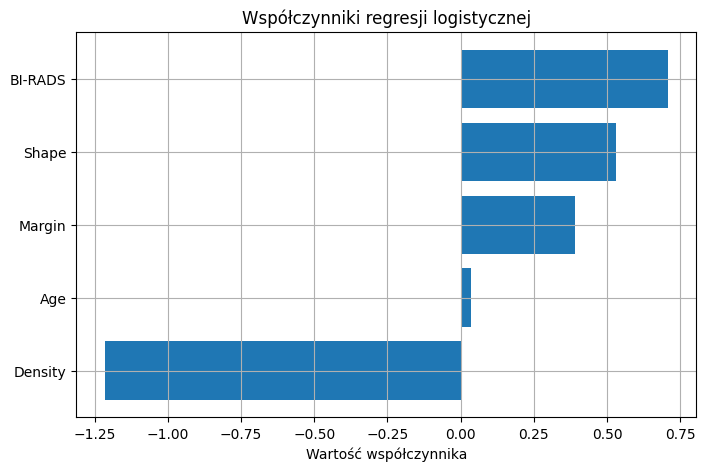

In [34]:
features = X.columns
coef = model.coef_[0]
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coef})
coef_df = coef_df.sort_values(by='Coefficient')

plt.figure(figsize=(8, 5))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.title('Współczynniki regresji logistycznej')
plt.xlabel('Wartość współczynnika')
plt.grid(True)
plt.show()

### Interpretacja wizualizacji

- **BI-RADS** ma największy pozytywny wpływ na decyzję modelu — im wyższa wartość tej cechy, tym większe prawdopodobieństwo klasy 1.
- **Shape** i **Margin** również pozytywnie wpływają na klasyfikację do klasy 1, choć w mniejszym stopniu.
- **Age** ma bardzo niewielki, ale dodatni wpływ.
- **Density** działa odwrotnie — wyższe wartości tej cechy obniżają prawdopodobieństwo przypisania do klasy 1.

## Wyjaśnienie wybranych decyzji

In [35]:
np.random.seed(42)
random_indices = np.random.choice(len(X_test), 3, replace=False)

intercept = model.intercept_[0]  
coef = model.coef_[0]

In [36]:
def minimal_change_to_flip_decision_logistic_regression(x, coef, intercept):
    z0 = np.dot(coef, x) + intercept
    changes = {}
    for i, w in enumerate(coef):
        if w != 0:
            delta = -z0 / w
            changes[x.index[i]] = delta
        else:
            changes[x.index[i]] = np.inf
    df = pd.DataFrame({
        'Feature': list(changes.keys()),
        'Current Value': x.values,
        'Coefficient': coef,
        'Required Change': list(changes.values()),
        'Value After Change': x.values + np.array(list(changes.values()))
    })
    return df

In [37]:
def sample_and_predict_changes_logistic_regression(x, coef, intercept, model, X_test, df_changes, original_pred):
    print("\nPróbkowanie zmienionych cech i wynik predykcji:")

    x_float = x.astype(float)

    for i, row in df_changes.iterrows():
        if np.isinf(row['Required Change']):
            print(f"- Cecha {row['Feature']} ma współczynnik 0, brak wpływu na decyzję.")
            continue
        
        x_modified = x_float.copy()
        delta = row['Required Change'] * 1.01
        x_modified[row['Feature']] += delta
        
        linear_sum_mod = np.dot(coef, x_modified) + intercept
        prob_mod = 1 / (1 + np.exp(-linear_sum_mod))
        pred_mod = model.predict(pd.DataFrame([x_modified], columns=X_test.columns))[0]
        
        changed = "TAK" if pred_mod != original_pred else "NIE"
        
        print(f"- Cecha {row['Feature']}: zmiana o {delta:.4f}, nowa wartość {x_modified[row['Feature']]:.4f}")
        print(f"  Prawdopodobieństwo klasy 1 po zmianie: {prob_mod:.4f}")
        print(f"  Predykcja po zmianie: {pred_mod}, zmiana klasy: {changed}")

In [38]:
masker = shap.maskers.Independent(X_test)
explainer = shap.LinearExplainer(model, masker=masker)

### Przykład 1

In [39]:
idx = random_indices[0]
x = X_test.iloc[idx]
linear_sum = np.dot(coef, x) + intercept
prob = 1 / (1 + np.exp(-linear_sum))
pred = model.predict(pd.DataFrame([x], columns=X_test.columns))[0]

print(f"Przykład 1 (indeks {idx} w zbiorze testowym):")
print(f"Wartości cech: BI-RADS={x.iloc[0]}, Age={x.iloc[1]}, Shape={x.iloc[2]}, Margin={x.iloc[3]}, Density={x.iloc[4]}")
print(f"Współczynniki: {coef}")
print(f"Wartości * współczynniki: {coef * x}")
print(f"Sumaryczna wartość liniowa (z interceptem): {linear_sum:.4f}")
print(f"Prawdopodobieństwo klasy 1: {prob:.4f}")
print(f"Przewidywana klasa: {pred}")

df_changes = minimal_change_to_flip_decision_logistic_regression(x, coef, intercept)
print("\nMinimalne zmiany wartości cech wymagane do zmiany decyzji modelu:")
print(df_changes)

Przykład 1 (indeks 161 w zbiorze testowym):
Wartości cech: BI-RADS=4, Age=62, Shape=4, Margin=2, Density=3
Współczynniki: [ 0.70888026  0.03563129  0.53040397  0.38980711 -1.21605076]
Wartości * współczynniki: BI-RADS    2.835521
Age        2.209140
Shape      2.121616
Margin     0.779614
Density   -3.648152
Name: 320, dtype: float64
Sumaryczna wartość liniowa (z interceptem): 0.0996
Prawdopodobieństwo klasy 1: 0.5249
Przewidywana klasa: 1

Minimalne zmiany wartości cech wymagane do zmiany decyzji modelu:
   Feature  Current Value  Coefficient  Required Change  Value After Change
0  BI-RADS              4     0.708880        -0.140510            3.859490
1      Age             62     0.035631        -2.795429           59.204571
2    Shape              4     0.530404        -0.187790            3.812210
3   Margin              2     0.389807        -0.255523            1.744477
4  Density              3    -1.216051         0.081908            3.081908


In [40]:
sample_and_predict_changes_logistic_regression(x, coef, intercept, model, X_test, df_changes, pred)


Próbkowanie zmienionych cech i wynik predykcji:
- Cecha BI-RADS: zmiana o -0.1419, nowa wartość 3.8581
  Prawdopodobieństwo klasy 1 po zmianie: 0.4998
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Age: zmiana o -2.8234, nowa wartość 59.1766
  Prawdopodobieństwo klasy 1 po zmianie: 0.4998
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Shape: zmiana o -0.1897, nowa wartość 3.8103
  Prawdopodobieństwo klasy 1 po zmianie: 0.4998
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Margin: zmiana o -0.2581, nowa wartość 1.7419
  Prawdopodobieństwo klasy 1 po zmianie: 0.4998
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Density: zmiana o 0.0827, nowa wartość 3.0827
  Prawdopodobieństwo klasy 1 po zmianie: 0.4998
  Predykcja po zmianie: 0, zmiana klasy: TAK


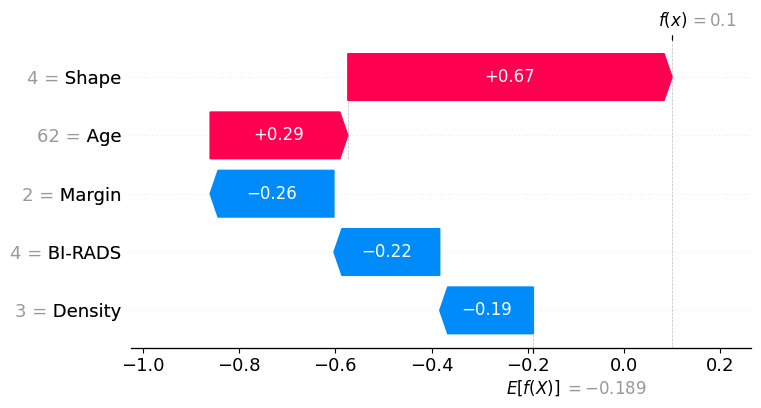

In [41]:
shap_values = explainer.shap_values(pd.DataFrame([x], columns=X_test.columns))
shap.initjs()
shap.plots.waterfall(shap.Explanation(values=shap_values[0], 
                                     base_values=explainer.expected_value, 
                                     data=x.values, 
                                     feature_names=X_test.columns))

Model przypisał obserwację do klasy 1, jednak decyzja jest niepewna, ponieważ suma ważonych cech z interceptem była blisko zera, dając prawdopodobieństwo klasy 1 tylko trochę większe od 0.50. 

- Największy pozytywny wpływ miały cechy: BI-RADS, Age i Shape.
- Cecha Density silnie obniżała sumę liniową, działając przeciwnie.
- Decyzja to efekt równowagi między cechami silnie pozytywnymi a jednym ujemnym czynnikiem.

Minimalna zmiana jednej cechy potrzebna do zmiany klasy jest odwrotnie proporcjonalna do jej współczynnika i przesuwa sumę liniową na drugą stronę progu decyzyjnego.

Próbkowanie wartości cech z nieznaczną nadwyżką ponad minimalne zmiany potwierdziło zmianę klasy zgodnie z przewidywaniami analitycznymi.

### Przykład 2

In [42]:
idx = random_indices[1]
x = X_test.iloc[idx]
linear_sum = np.dot(coef, x) + intercept
prob = 1 / (1 + np.exp(-linear_sum))
pred = model.predict(pd.DataFrame([x], columns=X_test.columns))[0]

print(f"Przykład 2 (indeks {idx} w zbiorze testowym):")
print(f"Wartości cech: BI-RADS={x.iloc[0]}, Age={x.iloc[1]}, Shape={x.iloc[2]}, Margin={x.iloc[3]}, Density={x.iloc[4]}")
print(f"Współczynniki: {coef}")
print(f"Wartości * współczynniki: {coef * x}")
print(f"Sumaryczna wartość liniowa (z interceptem): {linear_sum:.4f}")
print(f"Prawdopodobieństwo klasy 1: {prob:.4f}")
print(f"Przewidywana klasa: {pred}")

df_changes = minimal_change_to_flip_decision_logistic_regression(x, coef, intercept)
print("\nMinimalne zmiany wartości cech wymagane do zmiany decyzji modelu:")
print(df_changes)

Przykład 2 (indeks 15 w zbiorze testowym):
Wartości cech: BI-RADS=4, Age=58, Shape=2, Margin=1, Density=3
Współczynniki: [ 0.70888026  0.03563129  0.53040397  0.38980711 -1.21605076]
Wartości * współczynniki: BI-RADS    2.835521
Age        2.066615
Shape      1.060808
Margin     0.389807
Density   -3.648152
Name: 622, dtype: float64
Sumaryczna wartość liniowa (z interceptem): -1.4935
Prawdopodobieństwo klasy 1: 0.1834
Przewidywana klasa: 0

Minimalne zmiany wartości cech wymagane do zmiany decyzji modelu:
   Feature  Current Value  Coefficient  Required Change  Value After Change
0  BI-RADS              4     0.708880         2.106894            6.106894
1      Age             58     0.035631        41.916399           99.916399
2    Shape              2     0.530404         2.815845            4.815845
3   Margin              1     0.389807         3.831473            4.831473
4  Density              3    -1.216051        -1.228185            1.771815


In [43]:
sample_and_predict_changes_logistic_regression(x, coef, intercept, model, X_test, df_changes, pred)


Próbkowanie zmienionych cech i wynik predykcji:
- Cecha BI-RADS: zmiana o 2.1280, nowa wartość 6.1280
  Prawdopodobieństwo klasy 1 po zmianie: 0.5037
  Predykcja po zmianie: 1, zmiana klasy: TAK
- Cecha Age: zmiana o 42.3356, nowa wartość 100.3356
  Prawdopodobieństwo klasy 1 po zmianie: 0.5037
  Predykcja po zmianie: 1, zmiana klasy: TAK
- Cecha Shape: zmiana o 2.8440, nowa wartość 4.8440
  Prawdopodobieństwo klasy 1 po zmianie: 0.5037
  Predykcja po zmianie: 1, zmiana klasy: TAK
- Cecha Margin: zmiana o 3.8698, nowa wartość 4.8698
  Prawdopodobieństwo klasy 1 po zmianie: 0.5037
  Predykcja po zmianie: 1, zmiana klasy: TAK
- Cecha Density: zmiana o -1.2405, nowa wartość 1.7595
  Prawdopodobieństwo klasy 1 po zmianie: 0.5037
  Predykcja po zmianie: 1, zmiana klasy: TAK


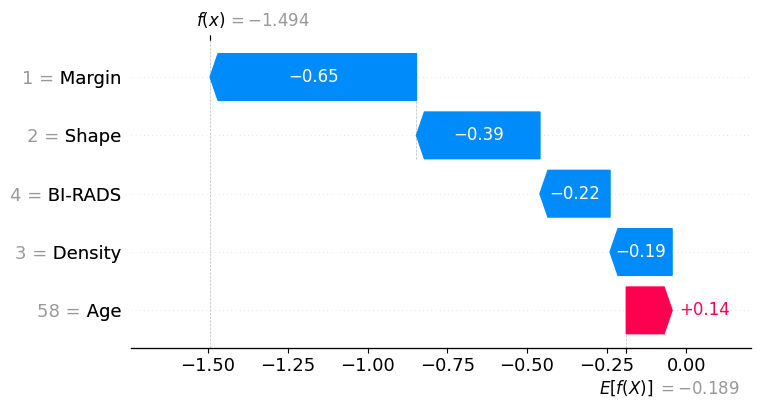

In [44]:
shap_values = explainer.shap_values(pd.DataFrame([x], columns=X_test.columns))
shap.initjs()
shap.plots.waterfall(shap.Explanation(values=shap_values[0], 
                                     base_values=explainer.expected_value, 
                                     data=x.values, 
                                     feature_names=X_test.columns))

Model przypisał obserwację do klasy 0 z dużą pewnością, ponieważ suma ważonych cech z interceptem była znacznie poniżej zera, dając prawdopodobieństwo klasy 1 około 0.18.

- Największy pozytywny wpływ miały cechy: BI-RADS, Age, Shape i Margin, jednak ich suma nie była wystarczająca.
- Cecha Density miała silny negatywny wpływ, jeszcze bardziej obniżając sumę liniową.
- Decyzja wynika z przewagi cech przeciwnych klasie 1.

Minimalna zmiana jednej cechy potrzebna do zmiany klasy jest odwrotnie proporcjonalna do jej współczynnika i wymaga przesunięcia sumy liniowej ponad próg decyzyjny.

Próbkowanie wartości cech z nieznaczną nadwyżką ponad minimalne zmiany potwierdziło zmianę klasy zgodnie z przewidywaniami analitycznymi.


### Przykład 3

In [45]:
idx = random_indices[2]
x = X_test.iloc[idx]
linear_sum = np.dot(coef, x) + intercept
prob = 1 / (1 + np.exp(-linear_sum))
pred = model.predict(pd.DataFrame([x], columns=X_test.columns))[0]

print(f"Przykład 3 (indeks {idx} w zbiorze testowym):")
print(f"Wartości cech: BI-RADS={x.iloc[0]}, Age={x.iloc[1]}, Shape={x.iloc[2]}, Margin={x.iloc[3]}, Density={x.iloc[4]}")
print(f"Współczynniki: {coef}")
print(f"Wartości * współczynniki: {coef * x}")
print(f"Sumaryczna wartość liniowa (z interceptem): {linear_sum:.4f}")
print(f"Prawdopodobieństwo klasy 1: {prob:.4f}")
print(f"Przewidywana klasa: {pred}")

df_changes = minimal_change_to_flip_decision_logistic_regression(x, coef, intercept)
print("\nMinimalne zmiany wartości cech wymagane do zmiany decyzji modelu:")
print(df_changes)

Przykład 3 (indeks 73 w zbiorze testowym):
Wartości cech: BI-RADS=5, Age=53, Shape=4, Margin=5, Density=3
Współczynniki: [ 0.70888026  0.03563129  0.53040397  0.38980711 -1.21605076]
Wartości * współczynniki: BI-RADS    3.544401
Age        1.888459
Shape      2.121616
Margin     1.949036
Density   -3.648152
Name: 479, dtype: float64
Sumaryczna wartość liniowa (z interceptem): 1.6572
Prawdopodobieństwo klasy 1: 0.8399
Przewidywana klasa: 1

Minimalne zmiany wartości cech wymagane do zmiany decyzji modelu:
   Feature  Current Value  Coefficient  Required Change  Value After Change
0  BI-RADS              5     0.708880        -2.337806            2.662194
1      Age             53     0.035631       -46.510372            6.489628
2    Shape              4     0.530404        -3.124458            0.875542
3   Margin              5     0.389807        -4.251397            0.748603
4  Density              3    -1.216051         1.362792            4.362792


In [46]:
sample_and_predict_changes_logistic_regression(x, coef, intercept, model, X_test, df_changes, pred)


Próbkowanie zmienionych cech i wynik predykcji:
- Cecha BI-RADS: zmiana o -2.3612, nowa wartość 2.6388
  Prawdopodobieństwo klasy 1 po zmianie: 0.4959
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Age: zmiana o -46.9755, nowa wartość 6.0245
  Prawdopodobieństwo klasy 1 po zmianie: 0.4959
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Shape: zmiana o -3.1557, nowa wartość 0.8443
  Prawdopodobieństwo klasy 1 po zmianie: 0.4959
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Margin: zmiana o -4.2939, nowa wartość 0.7061
  Prawdopodobieństwo klasy 1 po zmianie: 0.4959
  Predykcja po zmianie: 0, zmiana klasy: TAK
- Cecha Density: zmiana o 1.3764, nowa wartość 4.3764
  Prawdopodobieństwo klasy 1 po zmianie: 0.4959
  Predykcja po zmianie: 0, zmiana klasy: TAK


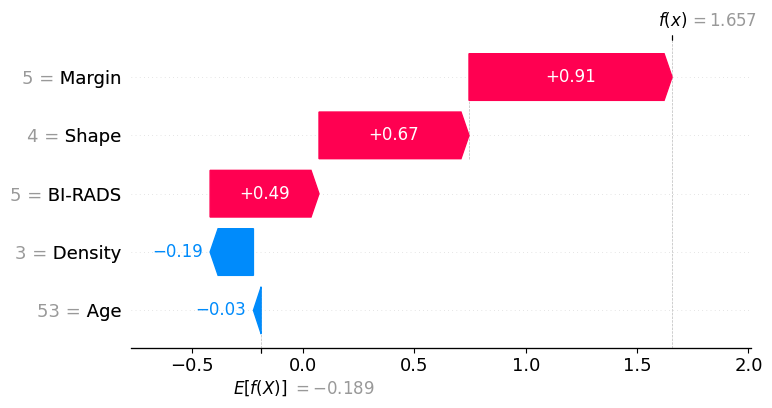

In [47]:
shap_values = explainer.shap_values(pd.DataFrame([x], columns=X_test.columns))
shap.initjs()
shap.plots.waterfall(shap.Explanation(values=shap_values[0], 
                                     base_values=explainer.expected_value, 
                                     data=x.values, 
                                     feature_names=X_test.columns))

Model przypisał obserwację do klasy 1 z wysokim prawdopodobieństwem, ponieważ suma ważonych cech z interceptem była wyraźnie powyżej zera.

- Największy pozytywny wpływ miały cechy: BI-RADS, Shape, Margin oraz Age, które znacząco podniosły sumę liniową.
- Cecha Density miała silny negatywny wpływ, częściowo obniżając sumę, ale nie na tyle, by zmienić decyzję.
- Decyzja modelu wynika z przewagi pozytywnych wartości cech nad negatywnym wpływem Density.

Minimalna zmiana wartości cech potrzebna do zmiany decyzji modelu jest odwrotnie proporcjonalna do ich współczynników i oznacza przesunięcie sumy liniowej poniżej progu decyzyjnego.

Próbkowanie wartości cech z niewielką nadwyżką ponad minimalne zmiany potwierdziło zmianę klasy zgodnie z przewidywaniami analitycznymi.

## Interpretacja modelu

Regresja logistyczna przewiduje prawdopodobieństwo wystąpienia złośliwego guza piersi (klasa 1) na podstawie wartości cech. Współczynniki modelu oraz wartości SHAP pokazują, że największy wpływ na decyzję mają cechy BI-RADS (najsilniejszy, pozytywny wpływ), Density (negatywny wpływ), a w mniejszym stopniu Shape i Margin. Wiek (Age) ma niewielką wagę, ale ze względu na dużą skalę wartości, jego wpływ na decyzję modelu jest zauważalny i częściowo rekompensuje niski współczynnik.

Wszystkie cechy mają charakter monotoniczny, co jest zgodne z naturą modelu liniowego — wyższe wartości niektórych cech zwiększają prawdopodobieństwo (BI-RADS, Shape, Margin, Age), inne je obniżają (Density). Nie zaobserwowano progów preferencji ani obszarów nierozróżnialności — wpływ cech zmienia się płynnie.

Podsumowując:
- **Preferencje** modelu wskazują na silny wpływ BI-RADS i Density.
- **Wszystkie cechy** mają wpływ; Age ma niską wagę, ale relatywnie duży zakres wartości.
- **Charakter cech**: BI-RADS, Shape, Margin, Age – zysk; Density – koszt.
- **Progi preferencji** nie występują – zmiany wpływu są liniowe i ciągłe.

### Wizualizacja funkcji cząstkowych zależności

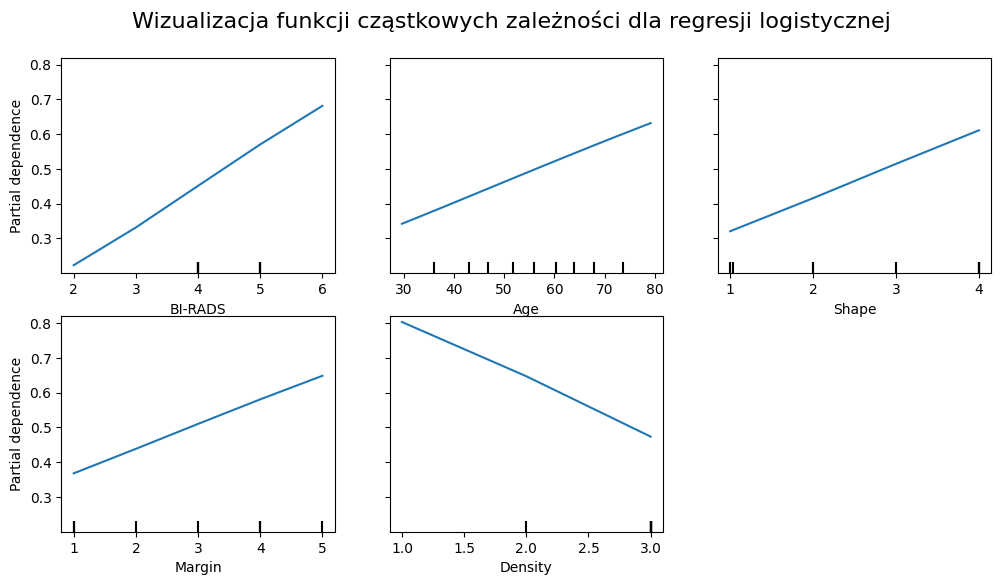

In [48]:
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(model, X_test, features, ax=ax, grid_resolution=50)
plt.suptitle('Wizualizacja funkcji cząstkowych zależności dla regresji logistycznej', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

Wykresy funkcji cząstkowych zależności pokazują, jak zmiana wartości poszczególnych cech wpływa na przewidywane prawdopodobieństwo przypisania do klasy 1, przy założeniu stałości pozostałych cech. Zależności mają kształt niemal liniowy, co jest zgodne z liniowym charakterem regresji logistycznej.

Wyniki uzyskane za pomocą tej techniki potwierdzają wcześniejsze wnioski dotyczące wpływu cech na decyzje modelu. Cecha BI-RADS ma największy wpływ, a Density działa w przeciwnym kierunku, co jest spójne z analizą współczynników regresji i wartości SHAP.
